# Interpretability

- https://shap.readthedocs.io/en/latest/

In [2]:
#!pip install shap

In [231]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
import shap
import matplotlib as plt

shap.initjs()
pd.options.display.max_columns = None

In [22]:
X1 = pd.read_csv('X1.csv')
X2 = pd.read_csv('X2.csv')
target = pd.read_csv('target.csv')

df_legend = pd.read_excel('df_project2.xlsx', sheet_name = 'data_dictionary') # read the data dictionary

## Model X1

In [121]:
existing_columns_x1 = X1.columns

numeric_cols_x1 = list(set(df_legend[df_legend['isnumeric']==1]['name_col']).intersection(existing_columns_x1))
yes_no_cols_x1 = list(set(df_legend[df_legend['no_yes_vars']==1]['name_col']).intersection(existing_columns_x1))
other_cols_x1 = list(set(df_legend[(df_legend['no_yes_vars']==0) & (df_legend['isnumeric']==0)]['name_col']).intersection(existing_columns_x1))

# add dummy columns that are missin from previous lists
missing_cols_x1 = set(existing_columns_x1).difference(numeric_cols).difference(yes_no_cols).difference(other_cols)

In [3]:
# model X1

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data_x1 = pd.read_csv('X1.csv', dtype=np.float64)
target = pd.read_csv('target.csv')

#features = tpot_data.drop('target', axis=1)
training_features_x1, testing_features_x1, training_target_x1, testing_target_x1 = \
            train_test_split(tpot_data_x1, target, random_state=25)

imputer = SimpleImputer(strategy="median")
imputer.fit(training_features_x1)
training_features_x1 = imputer.transform(training_features_x1)
testing_features_x1 = imputer.transform(testing_features_x1)

# Average CV score on the training set was: 0.9100745054544891
exported_pipeline_x1 = GradientBoostingClassifier(learning_rate=0.1, max_depth=1, max_features=0.4, 
                                                  min_samples_leaf=4, min_samples_split=19, 
                                                  n_estimators=100, subsample=0.35000000000000003)

exported_pipeline_x1.fit(training_features_x1, training_target_x1)
results_x1 = exported_pipeline_x1.predict(testing_features_x1)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [5]:
explainer_x1 = shap.TreeExplainer(exported_pipeline_x1)
shap_values_x1 = explainer_x1.shap_values(testing_features_x1)

pd.DataFrame(shap_values_x1).head()

0    1         2    3    4    5    6    7    8        9   ...  \
0 -0.011792  0.0  0.230459  0.0  0.0  0.0  0.0  0.0  0.0 -0.06061  ...   
1 -0.011792  0.0  0.018746  0.0  0.0  0.0  0.0  0.0  0.0 -0.06061  ...   
2 -0.011792  0.0  0.018746  0.0  0.0  0.0  0.0  0.0  0.0 -0.06061  ...   
3 -0.011792  0.0 -0.065225  0.0  0.0  0.0  0.0  0.0  0.0 -0.06061  ...   
4 -0.011792  0.0 -0.065225  0.0  0.0  0.0  0.0  0.0  0.0 -0.06061  ...   

         50        51   52   53        54   55   56   57   58   59  
0 -0.005348 -0.138103  0.0  0.0 -0.003211  0.0  0.0  0.0  0.0  0.0  
1 -0.005348 -0.037561  0.0  0.0 -0.003211  0.0  0.0  0.0  0.0  0.0  
2 -0.005348  0.418145  0.0  0.0 -0.003211  0.0  0.0  0.0  0.0  0.0  
3 -0.005348 -0.138103  0.0  0.0 -0.003211  0.0  0.0  0.0  0.0  0.0  
4 -0.005348 -0.138103  0.0  0.0 -0.003211  0.0  0.0  0.0  0.0  0.0  

[5 rows x 60 columns]

In [6]:
# add labels
df_testing_x1 = pd.DataFrame(testing_features_x1, columns = X1.columns)

### Global

#### Feature Importances

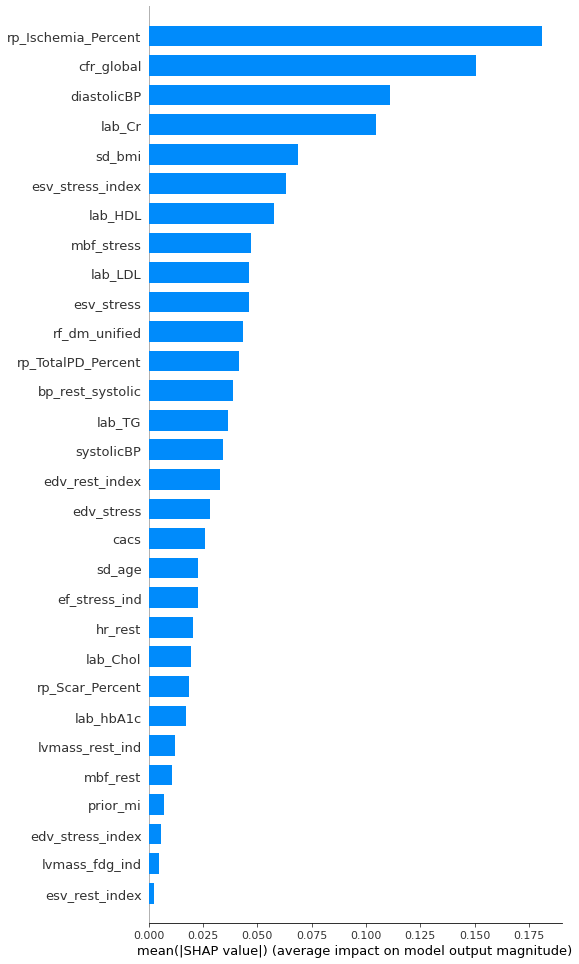

In [7]:
shap.summary_plot(shap_values_x1, df_testing_x1, plot_type="bar", max_display = 30)

#### SHAP Summary Plot

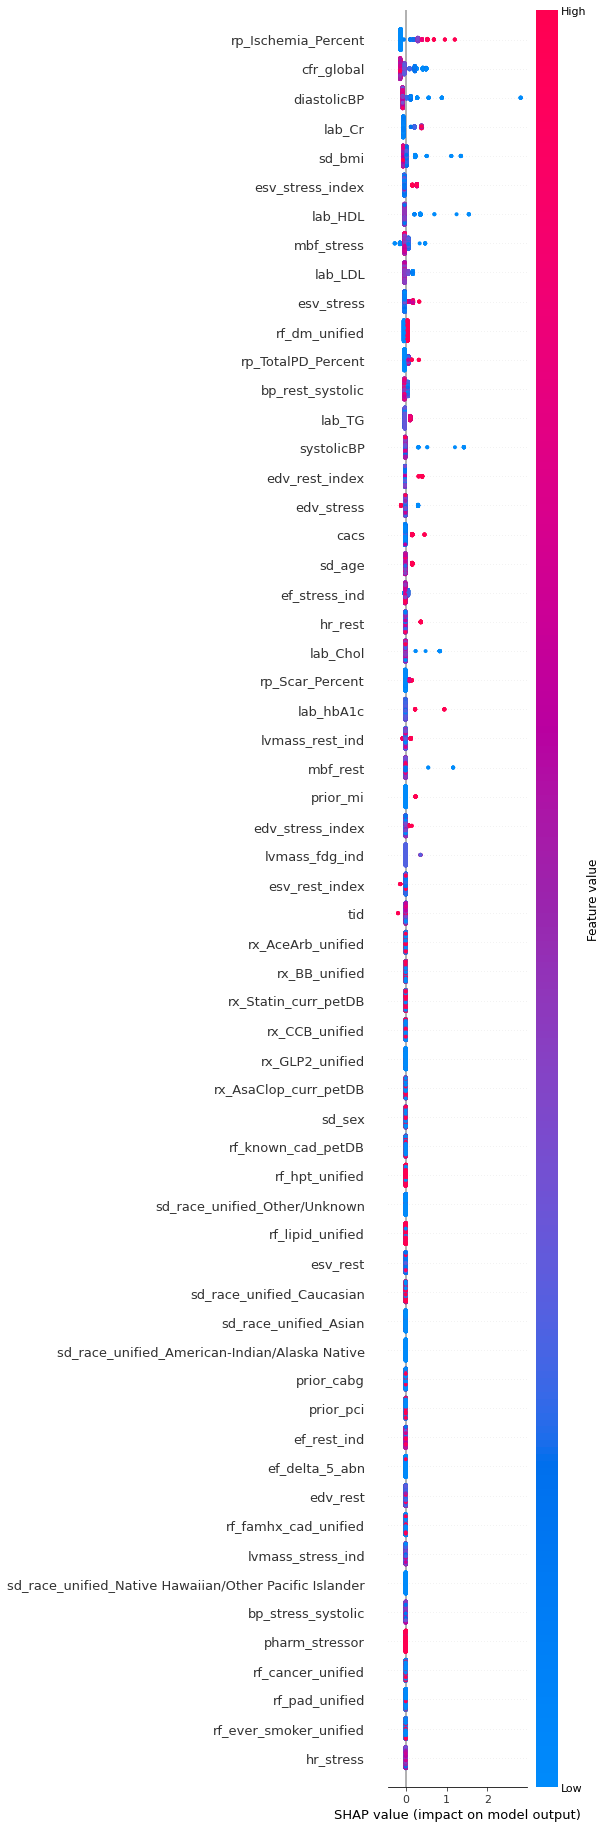

In [8]:
shap.summary_plot(shap_values_x1, df_testing_x1, max_display = 100)

#### PDP

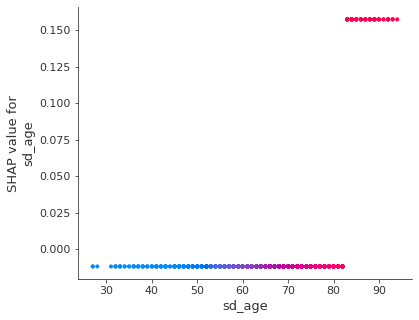

In [246]:
shap.dependence_plot(ind = 'sd_age', interaction_index = 'sd_age',
                     shap_values = shap_values_x1, 
                     features = df_testing_x1,
                    feature_names = df_testing_x1.columns)

### Local

In [10]:
# mace predicted as 1
np.where(results_x1 == 1)

(array([  23,   96,   99,  108,  242,  568,  572,  609,  661,  819,  828,
         906,  910,  932, 1015, 1036, 1068], dtype=int64),)

In [11]:
# actual values as 1
np.where(testing_target_x1 == 1)

(array([   1,   12,   23,   43,   61,   99,  109,  121,  125,  137,  145,
         155,  175,  190,  221,  223,  244,  289,  295,  303,  304,  323,
         364,  366,  454,  508,  534,  551,  568,  571,  572,  583,  588,
         596,  609,  610,  616,  624,  661,  670,  678,  684,  693,  744,
         748,  779,  792,  810,  819,  838,  866,  867,  889,  905,  974,
         978,  980,  996, 1015, 1025, 1036, 1052, 1068, 1075], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64))

In [12]:
# predicting when mace = 1
shap.initjs()
shap.force_plot(explainer_x1.expected_value, shap_values_x1[17,:], df_testing_x1.iloc[17,:]) # using index x

In [13]:
# predicting when mace=0
shap.initjs()
shap.force_plot(explainer_x1.expected_value, shap_values_x1[390,:], df_testing_x1.iloc[390,:]) # using index x

In [14]:
shap.initjs()
shap.force_plot(explainer_x1.expected_value, shap_values_x1[:1000,:], df_testing_x1.iloc[:1000,:])

### Group

In [81]:
df_results_x1 = pd.DataFrame(results_x1, columns = target.columns)
df_testing_x1 = pd.DataFrame(testing_features_x1, columns = X1.columns)

In [86]:
# combine results with features
combined = pd.concat([df_testing_x1, df_results_x1], axis=1)

sd_age  sd_sex  sd_bmi  rx_AsaClop_curr_petDB  rx_Statin_curr_petDB  \
1       67.0     0.0    26.7                    1.0                   0.0   
5       71.0     0.0    42.4                    1.0                   1.0   
7       72.0     0.0    26.1                    1.0                   1.0   
10      37.0     0.0    32.1                    0.0                   1.0   
13      61.0     0.0    37.4                    1.0                   1.0   
...      ...     ...     ...                    ...                   ...   
1071    74.0     0.0    24.8                    1.0                   1.0   
1072    78.0     0.0    34.1                    1.0                   1.0   
1076    68.0     0.0    31.1                    1.0                   1.0   
1077    64.0     0.0    28.8                    1.0                   1.0   
1080    60.0     0.0    39.9                    1.0                   1.0   

      rx_AceArb_unified  rx_BB_unified  rx_CCB_unified  rx_GLP2_unified  \
1                   0.0            1.0             0.0              0.0   
5                   1.0            0.0             1.0              0.0   
7                   1.0            0.0             0.0              0.0   
10                  1.0            0.0             0.0              0.0   
13                  0.0            1.0             0.0              0.0   
...                 ...            ...             ...              ...   
1071                0.0            1.0             1.0              0.0   
1072                1.0            0.0             0.0              0.0   
1076                1.0            1.0             0.0              0.0   
1077                1.0            1.0             0.0              0.0   
1080                0.0            1.0             1.0              1.0   

      lab_Cr  lab_hbA1c  lab_LDL  lab_HDL  lab_Chol  lab_TG  systolicBP  \
1       0.78        6.7     79.0     46.0     147.0   106.0       114.0   
5       1.00        6.0     79.0     46.0     147.0   106.0       159.0   
7       1.08        6.0     79.0     46.0     147.0   106.0       149.0   
10      0.72        5.7    157.0     33.0     208.0   157.0       145.0   
13      0.80        5.6     87.0     66.0     159.0    86.0       140.0   
...      ...        ...      ...      ...       ...     ...         ...   
1071    1.18        6.3     79.0     52.0     125.0    80.0       162.0   
1072    0.83        8.0     79.0     46.0     147.0   106.0       145.0   
1076    1.03        6.0    159.0     38.0     213.0    83.0       141.0   
1077    1.06        6.0     51.0     35.0      98.0    89.0       135.0   
1080    1.40        6.5     48.0     37.0     108.0   139.0       153.0   

      diastolicBP  rf_known_cad_petDB  rf_hpt_unified  rf_dm_unified  \
1            59.0                 1.0             1.0            1.0   
5            73.0                 1.0             1.0            1.0   
7            93.0                 0.0             1.0            0.0   
10           87.0                 0.0             1.0            0.0   
13           80.0                 0.0             1.0            0.0   
...           ...                 ...             ...            ...   
1071         87.0                 0.0             1.0            0.0   
1072         63.0                 1.0             1.0            1.0   
1076         90.0                 0.0             1.0            0.0   
1077         74.0                 1.0             1.0            0.0   
1080         79.0                 0.0             1.0            1.0   

      rf_lipid_unified  rf_famhx_cad_unified  rf_ever_smoker_unified  \
1                  1.0                   0.0                     0.0   
5                  1.0                   0.0                     0.0   
7                  1.0                   0.0                     0.0   
10                 1.0                   1.0                     0.0   
13                 1.0                   1.0          

In [241]:
# filter data takes in user given filters
# The expected input is a matrix where each array is a key, value pair
# Example of expected input [['sd_sex', 0],['sd_race_unified_Caucasian',1]]

def filterData(data, filters):
    filtered_data = data.copy()
    for filter_pair in filters:
        key, value = filter_pair
        filtered_data = filtered_data.loc[filtered_data[key] == value]
    
    return filtered_data
    
def getMaceArrays(data, filters):
    filtered = filterData(combined, test_filters)

    mace0 = filtered[filtered['o_mace'] == 0]
    mace0 = mace0.drop('o_mace', axis = 1)
    mace1 = filtered[filtered['o_mace'] == 1]
    mace1 = mace1.drop('o_mace', axis = 1)
    return [mace0, mace1]

def getAggregatedData(data, numeric_cols, yes_no_cols, other_cols):
    mace_median = data[numeric_cols].median()
    mace_mode = data[yes_no_cols + other_cols].mode()
    merged = pd.DataFrame(mace_median).T.merge(mace_mode)
    
    return merged

def createForcePlot(pipeline, data, title):
    shap.initjs()
    explainer = shap.TreeExplainer(pipeline)
    shap_values = explainer.shap_values(data)
    print(title)
    return shap.force_plot(explainer.expected_value, shap_values, data)


In [191]:
# select filters
test_filters = [['sd_sex', 1], ['sd_race_unified_Caucasian',1]]

# 2 datasets: mace=0, mace=1
mace0, mace1 = getMaceArrays(combined, test_filters)

In [218]:
# aggregate values for group level
mace_0_aggregated_x1 = getAggregatedData(mace0, numeric_cols_x1, yes_no_cols_x1, other_cols_x1)
mace_1_aggregated_x1 = getAggregatedData(mace1, numeric_cols_x1, yes_no_cols_x1, other_cols_x1)

In [242]:
# mace=0
createForcePlot(exported_pipeline_x1, mace_0_aggregated_x1, 'Mace 0')

Mace 0


In [243]:
# mace=1
createForcePlot(exported_pipeline_x1, mace_1_aggregated_x1, 'Mace 1')

Mace 1


## Model X2

In [ ]:
# model X2

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data_x2 = pd.read_csv('X2.csv', dtype=np.float64)
target = pd.read_csv('target.csv')

training_features_x2, testing_features_x2, training_target_x2, testing_target_x2 = \
            train_test_split(tpot_data_x2, target, random_state=25)

imputer = SimpleImputer(strategy="median")
imputer.fit(training_features_x2)
training_features_x2 = imputer.transform(training_features_x2)
testing_features_x2 = imputer.transform(testing_features_x2)

# Average CV score on the training set was: 0.90934345410496
exported_pipeline_x2 = make_pipeline(
    RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.15000000000000002, n_estimators=100), 
        step=0.9000000000000001),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.3, min_samples_leaf=12, 
                               min_samples_split=3, n_estimators=100, subsample=0.4))

exported_pipeline_x2.fit(training_features_x2, training_target_x2)
results_x2 = exported_pipeline_x2.predict(testing_features_x2)

### Global

#### Feature Importances

#### SHAP Summary Plot

### Local

### Group